In [5]:
import json
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from typing import Dict, List
from IPython.display import clear_output

import qiskit
from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import BasicAer
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [52]:
import matplotlib.pyplot as plt

#define utility functions

#this simulate a circuit (without measurement) and output results in the format of histogram.
def simulate(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    state_vector = result.get_statevector()
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram


def histogram_to_category(histogram):
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive

def count_gates(circuit: qiskit.QuantumCircuit) -> Dict[int, int]:
    """Returns the number of gate operations with each number of qubits."""
    return Counter([len(gate[1]) for gate in circuit.data])

def image_mse(image1,image2):
    # Using sklearns mean squared error:
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    return mean_squared_error(image1, image2)
#load the actual hackthon data (fashion-mnist)
images=np.load('images.npy')
labels=np.load('labels.npy')

In [8]:
sample_img = np.matrix(images[10])
def downsizing(sample_img):
    test_img = np.zeros((3,5))
    col_break_pt = [5,11,17,23,28]
    row_break_pt = [9,18,28]
    for i in range(3):
        for j in range(5):
            if j==0:
                test_img[i,j] = round(10*np.mean(sample_img[9*i:row_break_pt[i],:col_break_pt[j]]),4)
            else:
                test_img[i,j] = round(10*np.mean(sample_img[9*i:row_break_pt[i],col_break_pt[j-1]:col_break_pt[j]]),4)
    return test_img

In [9]:
def downsizing_2(sample_img):
    test_img = np.zeros((2,2))
    break_pt = [14,28]
    for i in range(2):
        for j in range(2):
            test_img[i,j] = round(np.mean(sample_img[14*i:break_pt[i],14*j:break_pt[j]]),5)
    return test_img

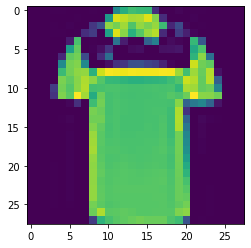

In [10]:
plt.imshow(sample_img)

In [11]:
test_img = downsizing_2(sample_img)

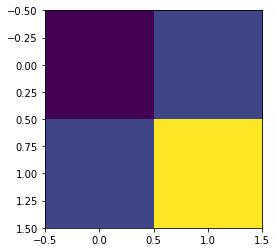

In [12]:
#test_img = downsizing(sample_img)
plt.imshow(test_img)

In [13]:
def reconstruction(test_img):
    img = np.zeros((28,28))
    min_img = 1e-4
    for i in range(9):
        for j in range(5):
            img[8-i,4-j] = abs(round(test_img[0,0] - j**3*1e-5 - 3*i*1e-6 - 2*min_img,2))

    for i in range(9):
        for j in range(5):
            img[8-i,23+j] = abs(round(test_img[0,4]-2*min_img -j**3*1e-5 -i*3*1e-6,2))



    for k in range(3):
        for i in range(9):
            for j in range(6):
                img[i,5+k*6 +j]= round(test_img[0,k+1]-5*(abs(k-1))*min_img+j*1e-6  +i*1e-6,5-2*abs(k-1))

    for i in range(9):
        for j in range(5):
            img[17-i,4-j] = abs(round(test_img[1,0] - j**3*1e-5 - 2*min_img,2))
    for i in range(9):
        for j in range(5):
            img[17-i,23+j] = abs(round(test_img[1,4]-2*min_img -j**3*1e-5 ,2))
    for k in range(3):
        for i in range(9):
            for j in range(6):
                img[9+i,5+k*6 +j]= round(test_img[1,k+1]-5*(abs(k-1))*min_img,5-2*abs(k-1))

    for i in range(10):
        for j in range(5):
            img[18+i,5-j] = abs(round(test_img[2,0] - j**3*1e-5 -i**3*1e-6  - 2*min_img,2))
    for i in range(10):
        for j in range(5):
            img[18+i,27-j] = abs(round(test_img[2,4]-2*min_img-i**3*1e-6  -j**3*1e-5 ,2))
    for k in range(3):
        for i in range(10):
            for j in range(6):
                img[18+i,5+k*6 +j]= round(test_img[2,k+1]-4*(abs(k-1))*min_img-i**3*1e-6 ,5)
    return img
#plt.imshow(reconstruction(test_img))

In [14]:
def reconstruction_2(image):
    img = np.zeros((28,28))
    min_img = 1e-4
    for i in range(14):
        for j in range(14):
            img[13-i,13-j] = max(round(test_img[0,0] - j*1e-5  - 2*min_img,5),0)

    for i in range(14):
        for j in range(14):
            img[13-i,13+j] = max(round(test_img[0,1]-2*min_img -j*1e-5 ,5),0)

    for i in range(14):
        for j in range(14):
            img[14+i,13- j]= max(round(test_img[1,0] - j**2*1e-5 - 0.5*i*1e-6 - 2*min_img,5),0)
    for i in range(14):
        for j in range(14):
            img[14+i,13+ j]= max(round(test_img[1,1] - j**2*1e-5 - 0.5*i*1e-6 - 2*min_img,5),0)
            
    return img

In [15]:
np.linalg.norm(reconstruction_2(test_img)-sample_img)

0.03844588342905314

In [16]:
def decode_2(histogram): 
    n=4
    options = {}
    hist_keys = list(histogram.keys())
    for i in range(n):
        options[i]=0
    for i in range(len(histogram)):
        for j in range(i,len(histogram)):
            x = hist_keys[i]^hist_keys[j]
            if x and (not(x & (x-1))):
                val1 = bin(hist_keys[i])[2:].zfill(n)
                val2 = bin(hist_keys[j])[2:].zfill(n)
                for k in range(n):
                    if val1[k]!=val2[k]:
                        if options[n-1-k] ==0:                            
                            options[n-1-k] = 2*np.arctan(np.sqrt(histogram[hist_keys[j]]/histogram[hist_keys[i]]))
            else:
                continue
    image = []
    for i in range(n):
        image.append(round(options[i]/10,4))
    return reconstruction_2(np.asarray(image).reshape((2,2)))

In [17]:
def decode(histogram): 
    n=16
    options = {}
    hist_keys = list(histogram.keys())
    for i in range(n):
        options[i]=0
    for i in range(len(histogram)):
        for j in range(i,len(histogram)):
            x = hist_keys[i]^hist_keys[j]
            if x and (not(x & (x-1))):
                val1 = bin(hist_keys[i])[2:].zfill(n)
                val2 = bin(hist_keys[j])[2:].zfill(n)
                for k in range(n):
                    if val1[k]!=val2[k]:
                        if options[n-1-k] ==0:                            
                            options[n-1-k] = 2*np.arctan(np.sqrt(histogram[hist_keys[j]]/histogram[hist_keys[i]]))
            else:
                continue
    image = []
    for i in range(n):
        image.append(round(options[i]/10,4))
    return reconstruction_2(np.asarray(image).reshape((4,4)))


In [18]:
def encode_qiskit(image):
    img_arr = np.asarray(downsizing(image)).reshape(-1)
    desired_state = img_arr
    q = qiskit.QuantumRegister(len(desired_state))
    circuit = qiskit.QuantumCircuit(q)
    i=0
    for ele in desired_state:
        if ele>1e-8:
            circuit.rx(10*ele,i)
        i+=1
    circuit.decompose().draw()
    return circuit

In [19]:
def encode_qiskit_2(image):
    img_arr = np.asarray(downsizing_2(image)).reshape(-1)
    desired_state = img_arr
    q = qiskit.QuantumRegister(len(desired_state))
    circuit = qiskit.QuantumCircuit(q)
    i=0
    for ele in desired_state:
        if ele>1e-8:
            circuit.rx(10*ele,i)
        i+=1
    circuit.decompose().draw()
    return circuit
J = sample_img
encode_qiskit_2(J).draw()
circuit=encode_qiskit_2(J)

#simulate circuit
histogram_2=simulate(circuit)

In [20]:

n = len(images)
mse=0
gatecount=0

for image in images[100:1000]:
    #encode image into circuit
    #J = downsizing(image)
    circuit=encode_qiskit_2(image)

    #simulate circuit
    histogram_2=simulate(circuit)

    #count the number of 2-qubit gates
    gatecount+=count_gates(circuit)[2]
    #print(gatecount)

    #reconstruct the image
    image_re=decode_2(histogram_2)
    #image_rec = reconstruction(downsizing(image))
    #calculate mse
    mse+=image_mse(np.asarray(image),image_re)
#fidelity of reconstruction
f=1-mse/n
gatecount=gatecount/n

#score for part1
print(f*(0.999**gatecount))



0.9999990666280378


In [21]:
J = sample_img
encode_qiskit(J).draw()

┌───────────┐
 q1803_0: ┤ Rx(0.011) ├
          ├───────────┤
 q1803_1: ┤ Rx(0.104) ├
          ├───────────┤
 q1803_2: ┤ Rx(0.194) ├
          ├───────────┤
 q1803_3: ┤ Rx(0.091) ├
          ├───────────┤
 q1803_4: ┤ Rx(0.018) ├
          ├───────────┤
 q1803_5: ┤ Rx(0.024) ├
          ├───────────┤
 q1803_6: ┤ Rx(0.202) ├
          ├───────────┤
 q1803_7: ┤ Rx(0.276) ├
          ├───────────┤
 q1803_8: ┤ Rx(0.222) ├
          ├───────────┤
 q1803_9: ┤ Rx(0.038) ├
          └───────────┘
q1803_10: ─────────────
          ┌───────────┐
q1803_11: ┤ Rx(0.147) ├
          ├───────────┤
q1803_12: ┤ Rx(0.289) ├
          ├───────────┤
q1803_13: ┤ Rx(0.188) ├
          └───────────┘
q1803_14: ─────────────

In [22]:
circuit=encode_qiskit(J)

#simulate circuit
histogram=simulate(circuit)

In [131]:
images[0].shape

(28, 28)

In [139]:

n = len(images)
mse=0
gatecount=0

for image in images[0:10]:
    #encode image into circuit
    #J = downsizing(image)
    circuit=encode_qiskit(image)

    #simulate circuit
    histogram=simulate(circuit)

    #count the number of 2-qubit gates
    gatecount+=count_gates(circuit)[2]
    #print(gatecount)

    #reconstruct the image
    image_re=decode(histogram)
    #image_rec = reconstruction(downsizing(image))
    #calculate mse
    mse+=image_mse(np.asarray(image),image_re)
#fidelity of reconstruction
f=1-mse/n
gatecount=gatecount/n

#score for part1
print(f*(0.999**gatecount))



0.9999999938363309


In [18]:
n = len(images)
n_train = int(0.75*n)
x_train = images[:n_train]
x_test = images[n_train:]
y_train = labels[:n_train]
y_test = labels[n_train:]

In [53]:
# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw()

┌───┐┌──────────┐                 ┌───┐┌─────────┐
q_0: ────────────┤ X ├┤ Rz(θ[0]) ├──■──────────────┤ X ├┤ Rz(π/2) ├
     ┌──────────┐└─┬─┘├──────────┤┌─┴─┐┌──────────┐└─┬─┘└─────────┘
q_1: ┤ Rz(-π/2) ├──■──┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[2]) ├──■─────────────
     └──────────┘     └──────────┘└───┘└──────────┘

In [54]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw()

┌───┐┌──────────┐                 ┌───┐┌─────────┐ ░ »
q_0: ────────────┤ X ├┤ Rz(θ[0]) ├──■──────────────┤ X ├┤ Rz(π/2) ├─░─»
     ┌──────────┐└─┬─┘├──────────┤┌─┴─┐┌──────────┐└─┬─┘└─────────┘ ░ »
q_1: ┤ Rz(-π/2) ├──■──┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[2]) ├──■──────────────░─»
     └──────────┘     └──────────┘└───┘└──────────┘                 ░ »
q_2: ───────────────────────────────────────────────────────────────░─»
                                                                    ░ »
q_3: ───────────────────────────────────────────────────────────────░─»
                                                                    ░ »
«                                                                    ░ »
«q_0: ───────────────────────────────────────────────────────────────░─»
«                                                                    ░ »
«q_1: ───────────────────────────────────────────────────────────────░─»
«                 ┌───┐┌──────────┐                 ┌───┐┌─────────┐ ░ »
«q_2: ────────────┤ X ├┤ Rz(θ[3]) ├──■──────────────┤ X ├┤ Rz(π/2) ├─░─»
«     ┌──────────┐└─┬─┘├──────────┤┌─┴─┐┌──────────┐└─┬─┘└─────────┘ ░ »
«q_3: ┤ Rz(-π/2) ├──■──┤ Ry(θ[4]) ├┤ X ├┤ Ry(θ[5]) ├──■──────────────░─»
«     └──────────┘     └──────────┘└───┘└──────────┘                 ░ »
«                                                                    ░ »
«q_0: ───────────────────────────────────────────────────────────────░─»
«                 ┌───┐┌──────────┐                 ┌───┐┌─────────┐ ░ »
«q_1: ────────────┤ X ├┤ Rz(θ[6]) ├──■──────────────┤ X ├┤ Rz(π/2) ├─░─»
«     ┌──────────┐└─┬─┘├──────────┤┌─┴─┐┌──────────┐└─┬─┘└─────────┘ ░ »
«q_2: ┤ Rz(-π/2) ├──■──┤ Ry(θ[7]) ├┤ X ├┤ Ry(θ[8]) ├──■──────────────░─»
«     └──────────┘     └──────────┘└───┘└──────────┘                 ░ »
«q_3: ───────────────────────────────────────────────────────────────░─»
«                                                                    ░ »
«     ┌──────────┐     ┌───────────┐┌───┐┌───────────┐                 ░ 
«q_0: ┤ Rz(-π/2) ├──■──┤ Ry(θ[10]) ├┤ X ├┤ Ry(θ[11]) ├──■──────────────░─
«     └──────────┘  │  └───────────┘└─┬─┘└───────────┘  │              ░ 
«q_1: ──────────────┼─────────────────┼─────────────────┼──────────────░─
«                   │                 │                 │              ░ 
«q_2: ──────────────┼─────────────────┼─────────────────┼──────────────░─
«                 ┌─┴─┐ ┌──────────┐  │               ┌─┴─┐┌─────────┐ ░ 
«q_3: ────────────┤ X ├─┤ Rz(θ[9]) ├──■───────────────┤ X ├┤ Rz(π/2) ├─░─
«                 └───┘ └──────────┘                  └───┘└─────────┘ ░

In [55]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw()

┌───┐┌──────────┐                 
q_0: ────────────┤ X ├┤ Rz(θ[0]) ├──■──────────────
     ┌──────────┐└─┬─┘├──────────┤┌─┴─┐┌──────────┐
q_1: ┤ Rz(-π/2) ├──■──┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[2]) ├
     └──────────┘     └──────────┘└───┘└──────────┘

In [56]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [i for i in range(0,2)]
sinks = [i for i in range(2,4)]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw()


┌───┐┌──────────┐                  ░                  »
q_0: ────────────┤ X ├┤ Rz(θ[0]) ├──■───────────────░──────────────────»
                 └─┬─┘└──────────┘  │               ░             ┌───┐»
q_1: ──────────────┼────────────────┼───────────────░─────────────┤ X ├»
     ┌──────────┐  │  ┌──────────┐┌─┴─┐┌──────────┐ ░             └─┬─┘»
q_2: ┤ Rz(-π/2) ├──■──┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[2]) ├─░───────────────┼──»
     └──────────┘     └──────────┘└───┘└──────────┘ ░ ┌──────────┐  │  »
q_3: ───────────────────────────────────────────────░─┤ Rz(-π/2) ├──■──»
                                                    ░ └──────────┘     »
«                                   ░ 
«q_0: ──────────────────────────────░─
«     ┌──────────┐                  ░ 
«q_1: ┤ Rz(θ[3]) ├──■───────────────░─
«     └──────────┘  │               ░ 
«q_2: ──────────────┼───────────────░─
«     ┌──────────┐┌─┴─┐┌──────────┐ ░ 
«q_3: ┤ Ry(θ[4]) ├┤ X ├┤ Ry(θ[5]) ├─░─
«     └──────────┘└───┘└──────────┘ ░

In [57]:
def generate_dataset_2(images,labels):
    n = len(images)
    img = []
    lab = []
    for image in images:
        img.append(10000*downsizing_2(image.reshape((28,28))).reshape(-1))
            
    for label in labels:
        lab.append(2*int(label)-1)
    return img,lab

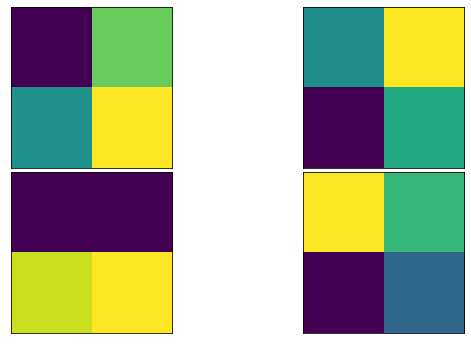

In [58]:
images, labels = generate_dataset_2(images,labels)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3
)

#Let’s see some examples in our dataset

fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(2, 2),  # Change back to 2 by 4
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)


In [59]:
feature_map = ZFeatureMap(4)
feature_map.decompose().draw()

┌───┐┌─────────────┐┌───┐┌─────────────┐
q_0: ┤ H ├┤ P(2.0*x[0]) ├┤ H ├┤ P(2.0*x[0]) ├
     ├───┤├─────────────┤├───┤├─────────────┤
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ H ├┤ P(2.0*x[1]) ├
     ├───┤├─────────────┤├───┤├─────────────┤
q_2: ┤ H ├┤ P(2.0*x[2]) ├┤ H ├┤ P(2.0*x[2]) ├
     ├───┤├─────────────┤├───┤├─────────────┤
q_3: ┤ H ├┤ P(2.0*x[3]) ├┤ H ├┤ P(2.0*x[3]) ├
     └───┘└─────────────┘└───┘└─────────────┘

In [60]:
feature_map = ZFeatureMap(4)

ansatz = QuantumCircuit(4, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(4, "с1"), list(range(4)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([i for i in range(0,2)], [i for i in range(2,4)], "p1"), list(range(4)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(2, "с2"), list(range(2,4)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0],[1], "p2"), list(range(2,4)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(4)
circuit.compose(feature_map, range(4), inplace=True)
circuit.compose(ansatz, range(4), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 3, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

In [61]:
circuit.draw()

┌───────────────────────────────────┐»
q_0: ┤0                                  ├»
     │                                   │»
q_1: ┤1                                  ├»
     │  ZFeatureMap(x[0],x[1],x[2],x[3]) │»
q_2: ┤2                                  ├»
     │                                   │»
q_3: ┤3                                  ├»
     └───────────────────────────────────┘»
«     ┌─────────────────────────────────────────────────────────────────────────────────────────────────┐»
«q_0: ┤0                                                                                                ├»
«     │                                                                                                 │»
«q_1: ┤1                                                                                                ├»
«     │  Convolutional Layer(с1[0],с1[1],с1[2],с1[3],с1[4],с1[5],с1[6],с1[7],с1[8],с1[9],с1[10],с1[11]) │»
«q_2: ┤2                                                                                                ├»
«     │                                                                                                 │»
«q_3: ┤3                                                                                                ├»
«     └─────────────────────────────────────────────────────────────────────────────────────────────────┘»
«     ┌─────────────────────────────────────────────────────┐»
«q_0: ┤0                                                    ├»
«     │                                                     │»
«q_1: ┤1                                                    ├»
«     │  Pooling Layer(p1[0],p1[1],p1[2],p1[3],p1[4],p1[5]) │»
«q_2: ┤2                                                    ├»
«     │                                                     │»
«q_3: ┤3                                                    ├»
«     └─────────────────────────────────────────────────────┘»
«                                                                  »
«q_0: ─────────────────────────────────────────────────────────────»
«                                                                  »
«q_1: ─────────────────────────────────────────────────────────────»
«     ┌───────────────────────────────────────────────────────────┐»
«q_2: ┤0                                                          ├»
«     │  Convolutional Layer(с2[0],с2[1],с2[2],с2[3],с2[4],с2[5]) │»
«q_3: ┤1                                                          ├»
«     └───────────────────────────────────────────────────────────┘»
«                                          
«q_0: ─────────────────────────────────────
«                                          
«q_1: ─────────────────────────────────────
«     ┌───────────────────────────────────┐
«q_2: ┤0                                  ├
«     │  Pooling Layer(p2[0],p2[1],p2[2]) │
«q_3: ┤1                                  ├
«     └───────────────────────────────────┘

In [62]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [63]:
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=50),  # Set max iterations here
    callback=callback_graph,
    #initial_point=initial_point,
)

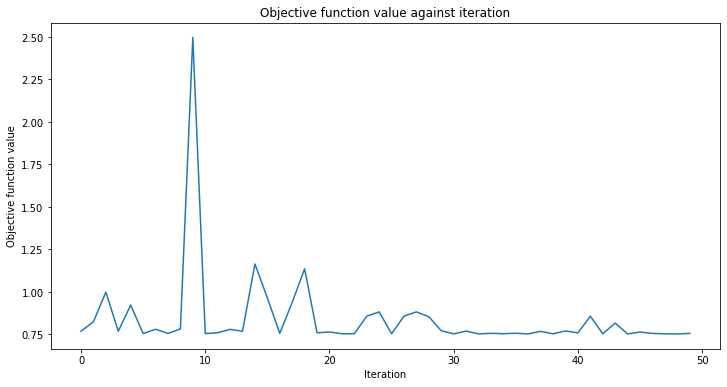

Accuracy from the train data : 74.79%


In [64]:
x = np.asarray(train_images)
y = np.asarray(train_labels)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

In [65]:
y_predict = classifier.predict(test_images)
x = np.asarray(test_images)
y = np.asarray(test_labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")



Accuracy from the test data : 75.5%


In [71]:
classifier.weights

array([-0.06097096,  0.31215586,  0.83878889,  0.76361032,  1.45990856,
       -0.15590199,  0.64400649,  0.10222339,  0.31533991,  1.62884812,
        0.02255037,  0.49543885,  0.2750945 ,  0.3822832 ,  0.27535739,
        0.09571064,  0.51137275,  0.16124619,  0.82325651,  0.70372868,
        1.13892989,  0.76994562,  0.47050509,  0.38785724,  0.08065382,
        0.44912872,  0.0163717 ])

In [84]:
ob = classifier
import pickle
file = open('part2.pickle','wb')
pickle.dump(ob,file)

In [86]:
pickled_model = pickle.load(open('part2.pickle', 'rb'))
pickled_model.predict(test_images), test_labels

(array([[-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-

In [ ]:
#grade part 2

#load classifier circuit
classifier=qiskit.QuantumCircuit.from_qasm_file('part2.qasm')
    
score=0

for data in dataset:
    #encode image into circuit
    circuit=encode_qiskit(data['image'])
    
    nq1 = circuit.width()
    nq2 = classifier.width()
    nq = max(nq1, nq2)
    qc = qiskit.QuantumCircuit(nq)
    qc.append(circuit.to_instruction(), list(range(nq1)))
    qc.append(classifier.to_instruction(), list(range(nq2)))

    gatecount+=count_gates(qc)[2]
    
    #simulate circuit
    histogram=simulate(qc)
    
    #convert histogram to category
    cat=histogram_to_category(histogram)
    
    
    if cat==data['category']:
        score+=1
#score
score=score/n
gatecount=gatecount/n

print(score*(0.999**gatecount))